In [2]:

import chess 
import chess.pgn 
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import statsmodels.api as sma
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
from statsmodels.discrete.discrete_model import Probit

endgame_threshold = 16
elo_threshold = 2250



# Business Understanding
I analysed a dataset of chess games to answer these three questions:

Are there differences in play between weak and strong players?

Are game statistics different when strong players play against weaker players?

Is the color White still a factor?

I distinguish between strong and weak players by their Elo rating. The threshold is 2250. I try to answer the difference in play by how many moves are played and how often is an endgame reached. I define an endgame when there are no more than 16 pieces on the board anymore. Other definitions are possible though. 

# Dataset Understanding
 I use a pgn file with roughly 140k games from players rated between 2000 and 2500 and the years 1980-1989. I chose this period because I wanted to have over the board games with longer time control.

 The rating is not always Elo and sometimes the import does not work. I handle the first by dropping non elo games and the second by working with try and except.

 I also delete some duplicates. In the end I have still around 110k games.

In [3]:
#Data Import/Preparation

#This takes some time. You don't have to run it, but import the csv file. 
#exec(open("C:\\Users\\TAMM\\Desktop\\udacity\\projekt1\\udacity_p1\\data_preparation.py").read())

df = pd.read_csv(filepath_or_buffer = "C:\\Users\\TAMM\\Desktop\\udacity\\projekt1\\udacity_p1\\game_result_list.csv", sep = ';')


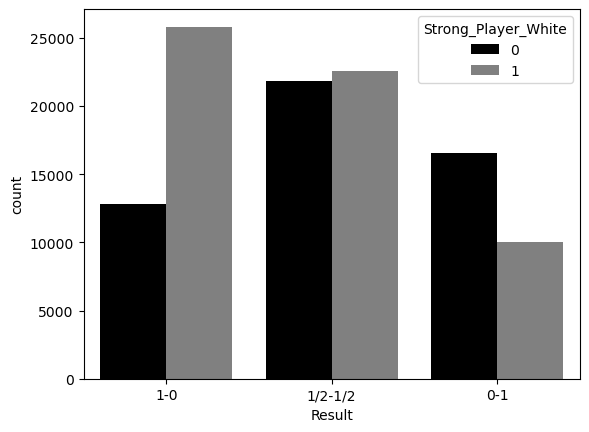

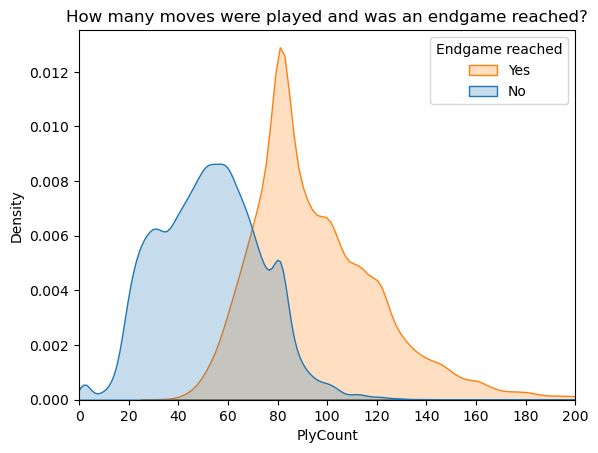

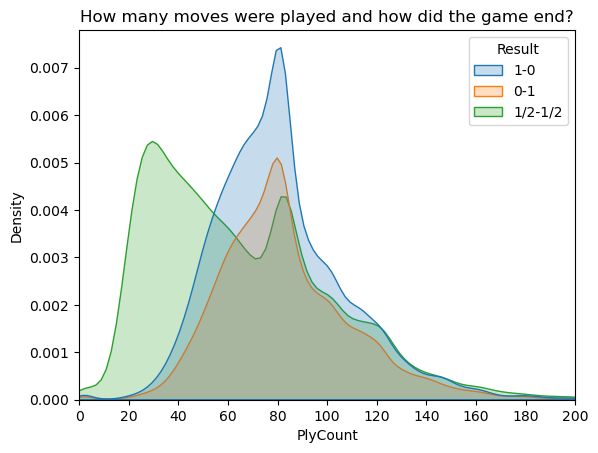

In [4]:

### Data Understanding with graphics

sns.countplot(data = df, x=df['Result'], palette = ['Black', 'Grey'], order=['1-0', '1/2-1/2', '0-1'], hue = df.Strong_Player_White )
plt.show()

sns.kdeplot(data=df, x=df['PlyCount'], legend = False, hue= df['Pieces'] <= endgame_threshold, fill=True)
plt.title('How many moves were played and was an endgame reached?')
plt.legend(title = 'Endgame reached' , loc='upper right', labels=['Yes', 'No'])
plt.xticks(ticks = [0,20,40,60,80,100,120,140,160, 180, 200])
plt.xlim(0,200)
plt.show()

sns.kdeplot(data=df, x=df['PlyCount'], legend = True, hue= df['Result'], fill=True)
plt.title('How many moves were played and how did the game end?')
plt.xticks(ticks = [0,20,40,60,80,100,120,140,160, 180, 200])
plt.xlim(0,200)
plt.show()


 The stronger player have more often White in my dataset and it is much easier to beat them when one plays White against them.

 When the game does not reach an endgame most games end around move 25 (PlyCount 50). Whether by a successful tactical skirmish or by draw we cannot see from figure 2.

 Around PlyCount 50 the number of games ending in an Endgame rises fast and reaching the maximum at around 80. I had to restrict the x-Axis to <= 200 to remove outliers.

 We see that endgames occure quite frequently and can take some time until the game ends. Thus endgame skills are needed for every ambitious chess player.

The third figure shows the first peak of draws around PlyCount 25-30, early draws directly after the opening. Another draw peak is after move 40.

 For decisive games it is different: the peak is before move 40. After move 40 usually the players get more time. Consequently they have little time before it and so errors happen more frequently. After move 40 the players take a fresh look at the position and convince themselves that a draw is not so bad.

## Data Understanding with numbers (1)

In [5]:
print(df.describe())

            WhiteElo       BlackElo       PlyCount         Pieces  \
count  109623.000000  109623.000000  109623.000000  109623.000000   
mean     2357.374702    2353.352399      75.455826      16.670288   
std       102.427239     101.865221      32.335671       6.520033   
min      2000.000000    2000.000000       1.000000       2.000000   
25%      2295.000000    2290.000000      54.000000      12.000000   
50%      2375.000000    2370.000000      74.000000      16.000000   
75%      2440.000000    2435.000000      93.000000      21.000000   
max      2500.000000    2500.000000     388.000000      32.000000   

         Probability        Result2  Strong_Player_Result  Strong_Player_Prob  \
count  109623.000000  109623.000000         109623.000000       109623.000000   
mean        0.505364       0.054911              0.588900            0.608083   
std         0.135893       0.381752              0.375295            0.082544   
min         0.057764      -0.500000              0.000

 We have 109623 games, and the White Elo is slightly better than Black's.\
 We have some games which ended already after 1 moves. This is mostly because the other player did not show up. \
 The median of PlyCount is 74,  which is about the mean, too. \
 On average the games ended with a little more than 16 pieces on the board, so over our Endgame Threshold.\
 The probability of White scoring is 0.505, because White's Elo a little bit higher.\
 The actual result was even better with 0.555 (We have to add 0.5 to Result2), indicating that the White pieces have an advantage.

## Data Understanding with numbers (2)
How often does an endgame arise?
### Are there differences in play between weak and strong players?
Do stronger players reach endgames more often on average?

In [7]:
#%%
#How often does an endgame arise?

endgame_cnt = df[df['Pieces']<=endgame_threshold].Pieces.count()
print("Share of endgames: %3.2f" %  (endgame_cnt/df.shape[0]))

### Are there differences in play between weak and strong players?

#Do stronger players reach endgames more often on average?
endgame_cnt1 = df[((df['Pieces']<=endgame_threshold) & ((df['BlackElo'] > elo_threshold) | (df['WhiteElo'] > elo_threshold)))].Pieces.count()
print("How often do stronger players reach an endgame? %3.2f" %  (endgame_cnt1/df[((df['BlackElo'] > elo_threshold) | (df['WhiteElo'] > elo_threshold))].shape[0]))

endgame_cnt2 = df[((df['Pieces']<=endgame_threshold) & ((df['BlackElo'] <= elo_threshold) | (df['WhiteElo'] <= elo_threshold)))].Pieces.count()
print("How often do weaker players reach an endgame? %3.2f" %  (endgame_cnt2/df[((df['BlackElo'] <= elo_threshold) | (df['WhiteElo'] <= elo_threshold))].shape[0]))


Share of endgames 0.53
How often do stronger players reach an endgame? 0.53
How often do weaker players reach an endgame? 0.54


We do not notice any difference between on Endgames stronger and weaker players.

In [8]:
############## MOVES

### Data Understanding with numbers (3)

#How many half-moves are played on average?
move_cnt = df.PlyCount.mean()
print("Average Number of half-moves %3.2f" %  (move_cnt))

### Are there differences in play between weak and strong players?

#Do stronger players play more moves on average?
print('Average number of half-moves for')
print('Stronger players: ', df[(df['BlackElo'] > elo_threshold) | (df['WhiteElo'] > elo_threshold)].PlyCount.mean())
print('Weaker players: ', df[(df['BlackElo'] <= elo_threshold) | (df['WhiteElo'] <= elo_threshold)].PlyCount.mean())


Average Number of half-moves 75.46
Average number of half-moves for
Stronger players:  75.37263377113274
Weaker players:  76.65608081101705


We do neither notice any difference on moves between stronger and weaker players.

### Are game statistics different when strong players play against weaker players?

In [12]:
############## STRONG VS WEAK
#Create dataset strong players vs weak players
strong_weak = df[((df['BlackElo'] <= elo_threshold) & (df['WhiteElo'] > elo_threshold)) | ((df['BlackElo'] > elo_threshold) & (df['WhiteElo'] <= elo_threshold))]

#How many moves do the games have?
print('Average half-moves in dataset: %5.3f' % (df.PlyCount.mean()))
print('Average half-moves when strong players face weak players: %5.3f' % (strong_weak.PlyCount.mean()))
print('--------------')
#How good is the performance of the stronger players vs. weaker players?

result = strong_weak.Strong_Player_Result.mean()
prob = strong_weak.Strong_Player_Prob.mean()
count = strong_weak.shape[0]

print('Number of games with strong vs weak players: ', count )
print('Avg. Points for stronger players really: %5.4f' % result)
print('Avg. Points for stronger players expected: %5.4f' % prob)
print('--------------')
##############
#How good is the performance of the stronger players if an endgame was reached vs. weaker players?

result  = strong_weak[strong_weak['Pieces'] <= endgame_threshold].Strong_Player_Result.mean()
prob = strong_weak[strong_weak['Pieces'] <= endgame_threshold].Strong_Player_Prob.mean()
count = strong_weak[strong_weak['Pieces'] <= endgame_threshold].shape[0]

print('Number of endgames with strong vs weak players: ', count)
print('Avg. Points for stronger players in endgame really: %5.4f' % result)
print('Avg. Points for stronger players in endgame expected: %5.4f' % prob)


Average half-moves in dataset: 75.456
Average half-moves when strong players face weak players: 76.703
--------------
Number of games with strong vs weak players:  19695
Avg. Points for stronger players really: 0.6481
Avg. Points for stronger players expected: 0.6952
--------------
Number of endgames with strong vs weak players:  10539
Avg. Points for stronger players in endgame really: 0.6411
Avg. Points for stronger players in endgame expected: 0.6943


 The game length does not vary a lot.
 When stronger players play weaker players they tend to score less points than expected, no matter if the games ends in an Endgame or not.
 Do you have an idea why this is so?


## Is White important for the win probability?
 We will answer this question with a OLS regression. We split the dataset into 70% training and 30% test. \
 The y variable will be the result from the stronger player's view. \
 Our X-variables will be the Elo Difference and a White-Dummy.

In [14]:
#How well was the outcome predicted by Elo on average?
print('Based on Elo Probability we expected %3.2f points for white and got %3.2f' % (df.Probability.mean(), df.Result2.mean()+0.5) )
print('--------------')
#Regression part

#Split into train and test

X = df[['Elo_Dif', 'Strong_Player_White']]
y = df['Strong_Player_Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

lm_model = LinearRegression(fit_intercept=True #normalize = True
    ) # Instantiate

lm_model.fit(X_train, y_train) #Fit

y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
print('R^2 Score on our test sample is: %5.4f' % (test_score))
print('In Training we had: %5.4f' % (train_score))
print('--------------')
#print('Mean predictions and real mean on traing set:  %5.4f vs %5.4f' %  (y_train_preds.mean(), y_train.mean()))
print('Mean predictions and real mean on test set: %5.4f vs %5.4f' % ( y_test_preds.mean(), y_test.mean()))
print('--------------')
#From https://www.cluzters.ai/forums/topic/395/find-p-value-significance-in-scikit-learn-linear-regression?c=1597

X_train2 = sma.add_constant(X_train)
est = sma.OLS(y_train, X_train2)
est2 = est.fit()
print(est2.summary())

Based on Elo Probability we expected 0.51 points for white and got 0.55
--------------
R^2 Score on our test sample is: 0.0439
In Training we had: 0.0460
--------------
Mean predictions and real mean on test set: 0.5884 vs 0.5911
--------------
                             OLS Regression Results                             
Dep. Variable:     Strong_Player_Result   R-squared:                       0.046
Model:                              OLS   Adj. R-squared:                  0.046
Method:                   Least Squares   F-statistic:                     1849.
Date:                  Tue, 02 May 2023   Prob (F-statistic):               0.00
Time:                          16:03:16   Log-Likelihood:                -31863.
No. Observations:                 76736   AIC:                         6.373e+04
Df Residuals:                     76733   BIC:                         6.376e+04
Df Model:                             2                                         
Covariance Type:          

We see that the color white is still highly significant and can give a 10%p rise in winning the game c.p. 
About the coefficient for Elo_Dif: It is 0.001, so 100 points more means 10% higher winning chances, so roughly 60%. https://www.318chess.com/elo.html says 64%, but we need to add half of the coeffient for White because Elo probability does not account for colours but we did. So our estimation is 65%, very close to the offiical one given our simple model design. 

#### How can we improve things?
  We only did an OLS regression, but the win probability based on Elo difference follows a normal or logit distribution, so a logit or probit regression would be better.  
 What would you suggest to others on how they can improve in chess?